In [191]:
!pip3 install pycalib

In [192]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV
from pycalib.metrics import binary_ECE
from pycalib.metrics import brier_score
import lime
from lime.lime_text import LimeTextExplainer


In [193]:
def load_data():
    train = pd.read_csv('/kaggle/input/games-review-sentiment/train.csv')
    test = pd.read_csv('/kaggle/input/games-review-sentiment/test.csv')
    return train, test

In [194]:
train, test = load_data()

Определяю функцию для того, чтобы починить неправильную кодировку для некоторых примеров из датасета

In [195]:
def fix_encoding(text):
    try:
        return text.encode('latin1').decode('cp1251') # кириллица
    except UnicodeEncodeError:
        return text
    except UnicodeDecodeError:
        try:
            return text.encode('latin1').decode('gbk') # китайский
        except:
            return text

Далее определяю функцию для очистки данных от NaN-ов, преобразования id в категориальный тип для дальнейшего применения к нему OneHotEncoder-а и применения выше определенной функции

In [196]:
def preprocess_data(train, test):    
    train['content'] = train['content'].fillna('').apply(fix_encoding)
    test['content'] = test['content'].fillna('').apply(fix_encoding)
    
    train['app_id'] = train['app_id'].astype(str)
    test['app_id'] = test['app_id'].astype(str)
    test_ids = test['id']

    X = train.drop(columns=['is_positive', 'id', 'author_id'])
    y = train['is_positive']
    return X, y, test_ids

При разбиении использую stratify для баланса по классам

In [197]:
X_train_full, y_train_full, test_ids = preprocess_data(train, test)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full)

Токенизирую текст по словам, а точнее n-граммам слов, а далее по n-граммам символов. Для символов лучше всего подошли  ngram_range=(3, 4). Пробовал использовать отдельно n-граммы слов, однако это ухудшило точность до ~0.905

In [198]:
word_vectorizer = ('word_tfidf', TfidfVectorizer(
    max_features=100000,
    ngram_range=(1, 2),
    stop_words='english',
    analyzer='word'
), 'content')

char_vectorizer = ('char_tfidf', TfidfVectorizer(
    max_features=100000,
    ngram_range=(3, 4),
    analyzer='char_wb'
), 'content')

Кодирую app_id OneHotEncoder-ом. В качестве модели выбрал логистическую регрессию, т.к. другие модели (XGBoost, LightGBM, RandomForest, а также стэкинг из XGBoost + LogReg) либо ухудшали (порядка 0.001) точность, либо переобучали модель, как, например, RandomForest. Также стоит отметить, что логистическая регрессия крайне быстро обучается и не требует GPU для быстрого обучения, как градиентный бустинг

In [199]:
preprocessor = ColumnTransformer(
    transformers=[
        word_vectorizer,
        char_vectorizer,
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['app_id'])
    ]
)

classifier = LogisticRegression(
    max_iter=10000000,
    random_state=42,
    n_jobs=-1,
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

Тестирую на валидационной выборке (0.2 данных от train.csv)

In [200]:
pipeline.fit(X_train, y_train)
valid_predictions = pipeline.predict(X_valid)
accuracy = accuracy_score(y_valid, valid_predictions)
roc_auc = roc_auc_score(y_valid, valid_predictions)
print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Validation ROC-AUC: {roc_auc:.4f}')

Validation Accuracy: 0.9147
Validation ROC-AUC: 0.9142


Получены хорошие показатели метрик

Обучаю уже на всем train.csv. Теперь предсказываю для test.csv для сабмита

In [201]:
pipeline.fit(X_train_full, y_train_full)
X_test = test.drop(columns=['id', 'author_id'], errors='ignore')
test_predictions = pipeline.predict(X_test)

result_df = pd.DataFrame({'id': test_ids, 'sentiment': test_predictions})
result_df.to_csv('predictions.csv', index=False)
print("Predictions saved to predictions.csv")

Predictions saved to predictions.csv


Аналогичным образом преобразовываю данные. Получаю decision_scores для логистической регрессии - выходы из линейной части

In [202]:
X_valid_tr = preprocessor.transform(X_valid)
decision_scores = classifier.decision_function(X_valid_tr)
print(decision_scores)

[ 5.94594171  3.77335284  1.86205964 ...  2.52004079  3.45985936
 -6.74866947]


Получаю предсказания по классам. Видно, что в случае бинарной классификации положительный класс предсказывается в случае, если decision_score >= 0, а отрицательный, если decision_score < 0

In [203]:
pred = classifier.predict(X_valid_tr)
print(pred)

[1 1 1 ... 1 1 0]


Смотрю, какие вероятности были получены на выходе сигмоиды. Видно, что в в данном случае высокие вероятности в случае, если decision_score ~= 3

In [204]:
classifier.predict_proba(X_valid_tr)

array([[0.00260961, 0.99739039],
       [0.02245891, 0.97754109],
       [0.13446316, 0.86553684],
       ...,
       [0.07446513, 0.92553487],
       [0.03047619, 0.96952381],
       [0.99882893, 0.00117107]])

Определяю функцию для построения гистограммы вероятностей по классу

In [205]:
def plot_hist(model, label: bool):
    probs = model.predict_proba(X_valid_tr)[:, label]
    
    plt.hist(probs, bins=100, color='magenta')
    plt.title('Распределение вероятностей для положительного класса')
    plt.show()

Вывожу гистограммы для обоих классов

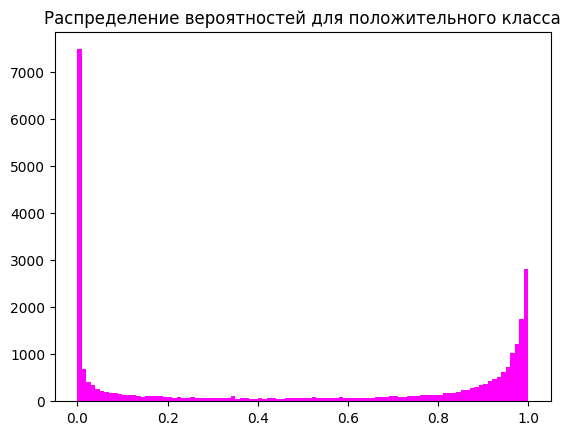

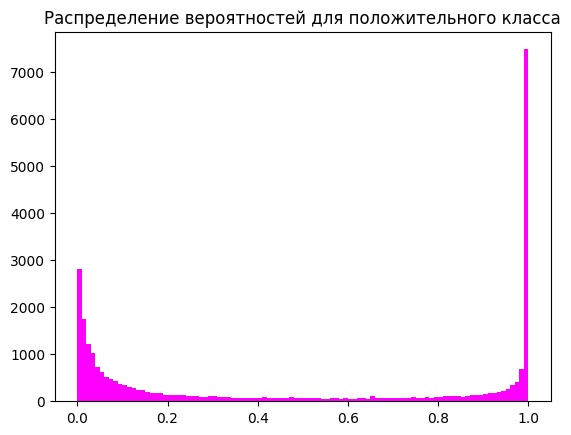

In [206]:
plot_hist(classifier, 1)
plot_hist(classifier, 0)

Определяю функцию для отображения графика калибровочной кривой, где серая пунктирная линия - идеальная кривая

In [207]:
def plot_calib_curve(model):
    y_prob = model.predict_proba(X_valid_tr)[:, 1] # вероятности модели
    true_probs, pred_probs = calibration_curve(y_valid, y_prob, n_bins=20)
    
    plt.plot(pred_probs, true_probs, 's-', label='Logistic Regression')
    plt.plot([0, 1], [0, 1], '--', color='gray', label='Идеальная калибровка')
    plt.xlabel(fr'Предсказанные вероятности для положительного класса')
    plt.ylabel(fr'Фактические вероятности для положительного класса')
    plt.legend()
    plt.show()

Строю калибровочную линию для логистической регрессии без калибровки. Видно, что она достаточно близка к диагонали, т.к. логистическая регрессия редко страдает проблемой из-за того, что она обучается приближать вероятности

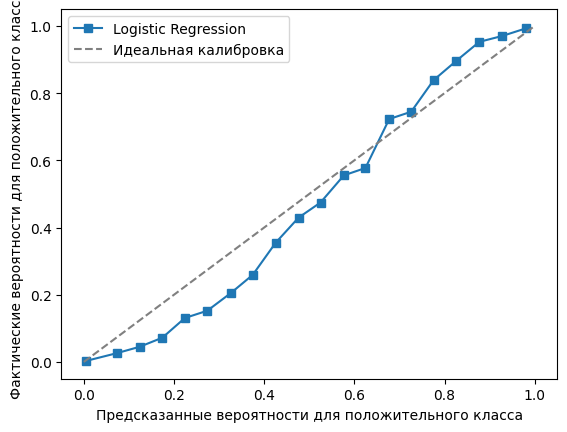

In [208]:
plot_calib_curve(classifier)

Калибрую модель при помощи калибровки Платта и строю для нее калибровочную кривую. Значимых отличий не видно

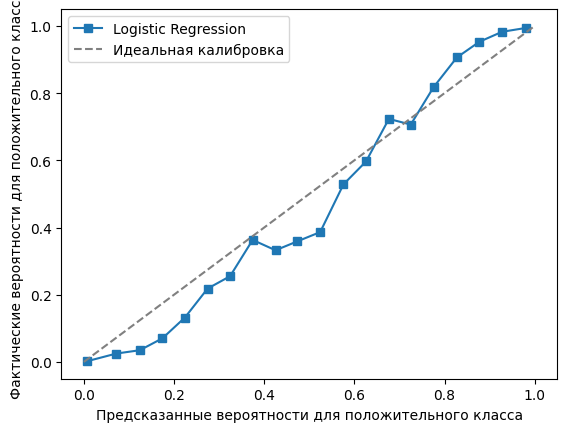

In [209]:
sigmoid_classifier = CalibratedClassifierCV(classifier, method='sigmoid', cv=5)
sigmoid_classifier.fit(X_valid_tr, y_valid)
plot_calib_curve(sigmoid_classifier)

Калибрую модель при помощи изотонической регрессии и строю для нее калибровочную кривую. Значимых отличий не видно

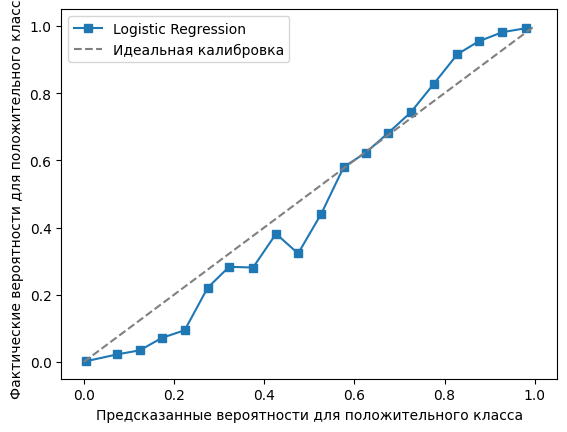

In [210]:
isotonic_classifier = CalibratedClassifierCV(classifier, method='isotonic', cv=5)
isotonic_classifier.fit(X_valid_tr, y_valid)
plot_calib_curve(isotonic_classifier)

Далее использую численные метрики, а именно Expected Calibration Error (ECE) и Brier score.

In [211]:
prob_base = classifier.predict_proba(X_valid_tr)[:, 1]
print('Base classifier binary-ECE = ', binary_ECE(y_valid, prob_base))

prob_sigm = sigmoid_classifier.predict_proba(X_valid_tr)[:, 1]
print('Calibrated w/ sigmoid classifier binary-ECE = ', binary_ECE(y_valid, prob_sigm))

prob_isot = isotonic_classifier.predict_proba(X_valid_tr)[:, 1]
print('Calibrated w/ isotonic classifier binary-ECE = ', binary_ECE(y_valid, prob_isot))

print('Base classifier brier score = ', brier_score(y_valid, prob_base))
print('Calibrated w/ sigmoid classifier brier score = ', brier_score(y_valid, prob_sigm))
print('Calibrated w/ isotonic classifier brier score = ', brier_score(y_valid, prob_isot))

Base classifier binary-ECE =  0.029386921899806198
Calibrated w/ sigmoid classifier binary-ECE =  0.03139684033118116
Calibrated w/ isotonic classifier binary-ECE =  0.030234928505658617
Base classifier brier score =  0.0470897847394471
Calibrated w/ sigmoid classifier brier score =  0.04798576545378696
Calibrated w/ isotonic classifier brier score =  0.04787622911882311


Из метрик видно, что после калибровки логистической регрессии, как калибровкой Платта, так и изотонической регрессией, она стала чуть хуже предсказывать вероятности. Отсюда можно сделать вывод, что для логистической регрессии калибровка не требуется

Далее провожу интерпретацию модели при помощи LIME (Local Interpretable Model Agnostic explanations)

In [212]:
explainer = LimeTextExplainer(class_names=['negative', 'positive'])
sample_text = X_valid.iloc[0]['content'] # беру первый элемент
print(f"Пример текста:\n{sample_text}\n")

Пример текста:
THE BEST MULTIPLAYER WORLD WAR 2 GAME PERIOD! I can't believe this game is still alive and doing extremely well. 10/10 would definitely recommend if you are playing with friends.



Определяю свою функцию для предсказания вероятностей, куда на вход подаются сгенерированные LIME тексты

In [213]:
def predict_proba(texts):
    data = pd.DataFrame({
        'content': texts,
        'app_id': [X_valid.iloc[0]['app_id']] * len(texts) # умножаем на кол-во сгенерированных текстов
    })
    return pipeline.predict_proba(data)

Генерирую объяснение для первого примера

In [214]:
exp = explainer.explain_instance(
    sample_text,
    predict_proba,
    num_features=10
)

exp.show_in_notebook()

Видно, что модель в данном примере дает наибольшие веса при предсказании положительного класса словам "10", "BEST", "definetely" и словам "cat", "extremely" при предсказании отрицательного класса. Слова "10", "BEST" очевидно определены верно